In [84]:
import os
from dotenv import load_dotenv

In [85]:
load_dotenv()

True

In [86]:
os.environ['ASTRA_DB_ID']=os.getenv('ASTRA_DB_ID')
os.environ['ASTRA_DB_API_ENDPOINT']=os.getenv('ASTRA_DB_API_ENDPOINT')
os.environ['ASTRA_DB_APPLICATION_TOKEN']=os.getenv('ASTRA_DB_APPLICATION_TOKEN')

In [87]:
import cassio
# connection of the astra db
cassio.init(token=os.environ['ASTRA_DB_APPLICATION_TOKEN'],database_id=os.environ['ASTRA_DB_ID'])

In [88]:
from langchain_text_splitters import RecursiveCharacterTextSplitter
from langchain_community.document_loaders import WebBaseLoader

urls=[
    "https://lilianweng.github.io/posts/2023-06-23-agent/",
    "https://lilianweng.github.io/posts/2023-03-15-prompt-engineering/",
    "https://lilianweng.github.io/posts/2023-10-25-adv-attack-llm/",
]

docs=[WebBaseLoader(url).load() for url in urls]
doc_list=[item for sublist in docs for item in sublist]
text_splitter=RecursiveCharacterTextSplitter.from_tiktoken_encoder(chunk_size=500,chunk_overlap=0)
docs_split=text_splitter.split_documents(doc_list)

In [89]:
from langchain_ollama import OllamaEmbeddings,ChatOllama
embedding=OllamaEmbeddings(model="llama3.1:8b")

In [90]:
from langchain_classic.vectorstores import Cassandra
astra_vector_store=Cassandra(embedding=embedding,table_name="qa_mini_demo",session=None,keyspace=None)

In [91]:
from langchain_classic.indexes.vectorstore import VectorStoreIndexWrapper
astra_vector_store.add_documents(doc_list)
print("Inserted %i headlines."%len(docs_split))
astra_vector_index=VectorStoreIndexWrapper(vectorstore=astra_vector_store)

Inserted 88 headlines.


In [92]:
retriever=astra_vector_store.as_retriever()


In [93]:
res=retriever.invoke("What is an agent?")

In [94]:
print(res)

[Document(id='b90df4358a88446a9e2bb8932be11435', metadata={'description': 'Prompt Engineering, also known as In-Context Prompting, refers to methods for how to communicate with LLM to steer its behavior for desired outcomes without updating the model weights. It is an empirical science and the effect of prompt engineering methods can vary a lot among models, thus requiring heavy experimentation and heuristics.\nThis post only focuses on prompt engineering for autoregressive language models, so nothing with Cloze tests, image generation or multimodality models. At its core, the goal of prompt engineering is about alignment and model steerability. Check my previous post on controllable text generation.', 'language': 'en', 'source': 'https://lilianweng.github.io/posts/2023-03-15-prompt-engineering/', 'title': "Prompt Engineering | Lil'Log"}, page_content='\n\n\n\n\n\nPrompt Engineering | Lil\'Log\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\nLil\'Log\n\n\n

In [95]:
from typing import Literal
from langchain_core.prompts import ChatPromptTemplate
from pydantic import Field,BaseModel
class RouteQuery(BaseModel):
    """Route a user query to the """
    datasource:Literal["vectorstore","wikisearch"]=Field(
        ...,
        description="Given a user question choose to route it to wikipedia or a vectorstore."
    )

In [96]:
llm=ChatOllama(model="llama3.1:8b")

In [97]:
structured_llm_router=llm.with_structured_output(RouteQuery)

In [98]:
system="""you are an expert at routing a user question to a vectorestore or wikipedia
. The vectorstore contains documents related to agents,prompt engineering, and adversarial attacks.
Use the vectorstore for questions on these topics. Otherwise, wiki search  
"""


route_prompt=ChatPromptTemplate.from_messages([
    ("system",system),
    ("human","{question}")
])

question_router=route_prompt|structured_llm_router

In [99]:
res=question_router.invoke({"question":"What is an agent?"})

In [100]:
res

RouteQuery(datasource='vectorstore')

In [101]:
from langchain_community.utilities import WikipediaAPIWrapper
from langchain_community.tools import WikipediaQueryRun
wiki_wrapper=WikipediaAPIWrapper(top_k_results=10,doc_content_chars_max=10)
wiki_query=WikipediaQueryRun(api_wrapper=wiki_wrapper)

In [102]:
res=wiki_query.run("Tell me about HFT.")

In [103]:
res

'Page: Mira'

In [104]:
from typing import List
from typing_extensions import TypedDict
from langgraph.graph import StateGraph,START,END
class GraphState(TypedDict):
    question:str
    generation:str
    documents:List[str]


In [105]:
from langchain_classic.schema import document

def retrieve(state):
    """
    Retrieve documents
    Args:
        state (dict): the current graph state
    Returns:
        state (dict): New key added to state, documents, that contains retrieved documents
    """
    print("---Retrieve---")
    questions=state["question"]


    ## Retrieval
    documents=retriever.invoke(questions)
    return {"documents":documents,"questions":questions}

In [106]:
from langchain_core.documents import Document

In [107]:
def wiki_search(state):
    """
    wiki search based on the re-phrased question.

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): Updates documents key with appended web results
    """

    print("---wikipedia---")
    print("---HELLO--")
    question = state["question"]
    print(question)

    # Wiki search
    docs = wiki_query.invoke({"query": question})
    #print(docs["summary"])
    wiki_results = docs
    wiki_results = Document(page_content=wiki_results)

    return {"documents": wiki_results, "question": question}

In [108]:
### Edges ###


def route_question(state):
    """
    Route question to wiki search or RAG.

    Args:
        state (dict): The current graph state

    Returns:
        str: Next node to call
    """

    print("---ROUTE QUESTION---")
    question = state["question"]
    source = question_router.invoke({"question": question})
    if source.datasource == "wiki_search":
        print("---ROUTE QUESTION TO Wiki SEARCH---")
        return "wiki_search"
    elif source.datasource == "vectorstore":
        print("---ROUTE QUESTION TO RAG---")
        return "vectorstore"

In [109]:
### Edges ###


def route_question(state):
    """
    Route question to wiki search or RAG.

    Args:
        state (dict): The current graph state

    Returns:
        str: Next node to call
    """

    print("---ROUTE QUESTION---")
    question = state["question"]
    source = question_router.invoke({"question": question})
    if source.datasource == "wiki_search":
        print("---ROUTE QUESTION TO Wiki SEARCH---")
        return "wiki_search"
    elif source.datasource == "vectorstore":
        print("---ROUTE QUESTION TO RAG---")
        return "vectorstore"

In [110]:
workflow = StateGraph(GraphState)
# Define the nodes
workflow.add_node("wiki_search", wiki_search)  # web search
workflow.add_node("retrieve", retrieve)  # retrieve

# Build graph
workflow.add_conditional_edges(
    START,
    route_question,
    {
        "wiki_search": "wiki_search",
        "vectorstore": "retrieve",
    },
)
workflow.add_edge( "retrieve", END)
workflow.add_edge( "wiki_search", END)
# Compile
app = workflow.compile()

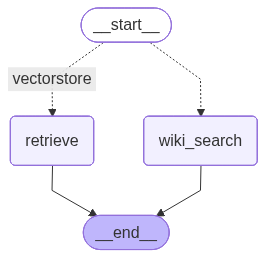

In [111]:
from IPython.display import Image, display

try:
    display(Image(app.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

In [112]:
from pprint import pprint

# Run
inputs = {
    "question": "What is agent?"
}
for output in app.stream(inputs):
    for key, value in output.items():
        # Node
        pprint(f"Node '{key}':")
        # Optional: print full state at each node
        # pprint.pprint(value["keys"], indent=2, width=80, depth=None)
    pprint("\n---\n")

# Final generation
pprint(value['documents'][0].dict()['metadata']['description'])

---ROUTE QUESTION---
---ROUTE QUESTION TO RAG---
---Retrieve---
"Node 'retrieve':"
'\n---\n'
('Prompt Engineering, also known as In-Context Prompting, refers to methods '
 'for how to communicate with LLM to steer its behavior for desired outcomes '
 'without updating the model weights. It is an empirical science and the '
 'effect of prompt engineering methods can vary a lot among models, thus '
 'requiring heavy experimentation and heuristics.\n'
 'This post only focuses on prompt engineering for autoregressive language '
 'models, so nothing with Cloze tests, image generation or multimodality '
 'models. At its core, the goal of prompt engineering is about alignment and '
 'model steerability. Check my previous post on controllable text generation.')


/tmp/ipykernel_169088/2686642801.py:16: PydanticDeprecatedSince20: The `dict` method is deprecated; use `model_dump` instead. Deprecated in Pydantic V2.0 to be removed in V3.0. See Pydantic V2 Migration Guide at https://errors.pydantic.dev/2.12/migration/
  pprint(value['documents'][0].dict()['metadata']['description'])


In [113]:
from pprint import pprint

# Run
inputs = {
    "question": "Avengers"
}
for output in app.stream(inputs):
    for key, value in output.items():
        # Node
        pprint(f"Node '{key}':")
        # Optional: print full state at each node
        # pprint.pprint(value["keys"], indent=2, width=80, depth=None)
    pprint("\n---\n")

# Final generation
pprint(value['documents'])

---ROUTE QUESTION---


KeyError: None

Inserted 88 chunks.
[Document(id='813dce80b5b4480eaabbf9fb7fbf906a', metadata={'description': 'Prompt Engineering, also known as In-Context Prompting, refers to methods for how to communicate with LLM to steer its behavior for desired outcomes without updating the model weights. It is an empirical science and the effect of prompt engineering methods can vary a lot among models, thus requiring heavy experimentation and heuristics.\nThis post only focuses on prompt engineering for autoregressive language models, so nothing with Cloze tests, image generation or multimodality models. At its core, the goal of prompt engineering is about alignment and model steerability. Check my previous post on controllable text generation.', 'language': 'en', 'source': 'https://lilianweng.github.io/posts/2023-03-15-prompt-engineering/', 'title': "Prompt Engineering | Lil'Log"}, page_content='RAG style, $p(a_i \\mid q) = \\sum_{i=1}^n p_\\text{tf-idf} (p_i \\mid q) \\cdot p_\\text{LM}(a_i \\mid q, p_i)$, w

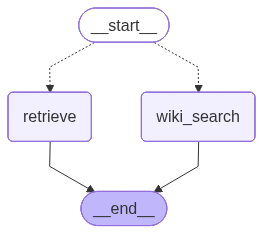

---ROUTE QUESTION---


/tmp/ipykernel_169088/1602952074.py:160: PydanticDeprecatedSince20: The `dict` method is deprecated; use `model_dump` instead. Deprecated in Pydantic V2.0 to be removed in V3.0. See Pydantic V2 Migration Guide at https://errors.pydantic.dev/2.12/migration/
  source = source.dict()


Datasource chosen: vectorstore
---Retrieve---
"Node 'retrieve':"
'\n---\n'
('RAG style, $p(a_i \\mid q) = \\sum_{i=1}^n p_\\text{tf-idf} (p_i \\mid q) '
 '\\cdot p_\\text{LM}(a_i \\mid q, p_i)$, where $p_\\text{tf-idf} (p_i \\mid '
 'q)$ is the normalized cosine similarities between the TF-IDF passage and '
 'question representations.\n'
 'Noisy channel inference, $p(a_i\\mid q) = \\frac{p_\\text{LM}(q \\mid a_i, '
 'p_i) \\cdot p_\\text{LM}(a_i \\mid p_i)}{p_\\text{LM}(q \\mid p_i)}$\n'
 'Product-of-Experts (PoE), combines all probabilities used above in addition '
 'to $p_\\text{LM}(p_i \\mid q)$.\n'
 '\n'
 'According to their ')
('MRKL (Karpas et al. 2022), short for “Modular Reasoning, Knowledge and '
 'Language”, is a neuro-symbolic architecture for autonomous agents. A MRKL '
 'system is proposed to contain a collection of “expert” modules and the '
 'general-purpose LLM works as a router to route inquiries to the best '
 'suitable expert module. These modules can be neural (e.g.

/home/workstation-p/anaconda3/envs/conda-env-3-12/lib/python3.12/site-packages/wikipedia/wikipedia.py:389: GuessedAtParserWarning: No parser was explicitly specified, so I'm using the best available HTML parser for this system ("lxml"). This usually isn't a problem, but if you run this code on another system, or in a different virtual environment, it may use a different parser and behave differently.

The code that caused this warning is on line 389 of the file /home/workstation-p/anaconda3/envs/conda-env-3-12/lib/python3.12/site-packages/wikipedia/wikipedia.py. To get rid of this warning, pass the additional argument 'features="lxml"' to the BeautifulSoup constructor.

  lis = BeautifulSoup(html).find_all('li')


"Node 'wiki_search':"
'\n---\n'
('Page: Avengers: Endgame\n'
 'Summary: Avengers: Endgame is a 2019 American superhero film based on the '
 'Marvel Comics superhero team the Avengers. Produced by Marvel Studios and '
 'distributed by Walt Disney Studios Motion Pictures, it is the direct sequel '
 'to Avengers: Infinity War (2018) and the 22nd film in the Marvel Cinematic '
 'Universe (MCU). Directed by Anthony and Joe Russo and written by Christopher '
 'Markus and Stephen McFeely, the film features an ensemble cast that includes '
 'Robert Downey Jr., Chri')


In [114]:
# %%
import os
from dotenv import load_dotenv

# %%
load_dotenv()

# %%
os.environ['ASTRA_DB_ID'] = os.getenv('ASTRA_DB_ID')
os.environ['ASTRA_DB_API_ENDPOINT'] = os.getenv('ASTRA_DB_API_ENDPOINT')
os.environ['ASTRA_DB_APPLICATION_TOKEN'] = os.getenv('ASTRA_DB_APPLICATION_TOKEN')

# %%
import cassio
# Connect to Astra DB
cassio.init(
    token=os.environ['ASTRA_DB_APPLICATION_TOKEN'],
    database_id=os.environ['ASTRA_DB_ID']
)

# %%
from langchain_text_splitters import RecursiveCharacterTextSplitter
from langchain_community.document_loaders import WebBaseLoader

urls = [
    "https://lilianweng.github.io/posts/2023-06-23-agent/",
    "https://lilianweng.github.io/posts/2023-03-15-prompt-engineering/",
    "https://lilianweng.github.io/posts/2023-10-25-adv-attack-llm/",
]

docs = [WebBaseLoader(url).load() for url in urls]
doc_list = [item for sublist in docs for item in sublist]

text_splitter = RecursiveCharacterTextSplitter.from_tiktoken_encoder(
    chunk_size=500,
    chunk_overlap=0
)
docs_split = text_splitter.split_documents(doc_list)

# %%
from langchain_ollama import OllamaEmbeddings, ChatOllama
embedding = OllamaEmbeddings(model="llama3.1:8b")

# %%
from langchain_classic.vectorstores import Cassandra
astra_vector_store = Cassandra(
    embedding=embedding,
    table_name="qa_mini_demo",
    session=None,
    keyspace=None
)

# %%
from langchain_classic.indexes.vectorstore import VectorStoreIndexWrapper
astra_vector_store.add_documents(docs_split)
print("Inserted %i chunks." % len(docs_split))
astra_vector_index = VectorStoreIndexWrapper(vectorstore=astra_vector_store)

# %%
retriever = astra_vector_store.as_retriever()

# %%
res = retriever.invoke("What is an agent?")
print(res)

# %%
from typing import Literal
from langchain_core.prompts import ChatPromptTemplate
from pydantic import Field, BaseModel

class RouteQuery(BaseModel):
    """Route a user query to a vectorstore or wiki search."""
    datasource: Literal["vectorstore", "wiki_search"] = Field(
        ...,
        description="Choose to route question to vectorstore or Wikipedia."
    )

# %%
llm = ChatOllama(model="llama3.1:8b")
structured_llm_router = llm.with_structured_output(RouteQuery)

# %%
system = """You are an expert at routing a user question to a vectorstore or Wikipedia.
The vectorstore contains documents related to agents, prompt engineering, and adversarial attacks.
Use the vectorstore for questions on these topics. Otherwise, use Wikipedia search."""

route_prompt = ChatPromptTemplate.from_messages([
    ("system", system),
    ("human", "{question}")
])

question_router = route_prompt | structured_llm_router

# %%
res = question_router.invoke({"question": "What is an agent?"})
print(res)

# %%
from langchain_community.utilities import WikipediaAPIWrapper
from langchain_community.tools import WikipediaQueryRun

wiki_wrapper = WikipediaAPIWrapper(top_k_results=10, doc_content_chars_max=1000)
wiki_query = WikipediaQueryRun(api_wrapper=wiki_wrapper)

# %%
res = wiki_query.run("Tell me about HFT.")
print(res)

# %%
from typing import List
from typing_extensions import TypedDict
from langgraph.graph import StateGraph, START, END

class GraphState(TypedDict):
    question: str
    generation: str
    documents: List[str]

# %%
from langchain_core.documents import Document

# %%
def retrieve(state):
    """Retrieve documents from vectorstore."""
    print("---Retrieve---")
    question = state["question"]
    documents = retriever.invoke(question)
    
    # Ensure it's always a list of Document
    if not isinstance(documents, list):
        documents = [documents]
    
    return {"documents": documents, "question": question}

# %%
def wiki_search(state):
    """Retrieve documents from Wikipedia."""
    print("---Wikipedia Search---")
    question = state["question"]
    
    docs = wiki_query.invoke({"query": question})
    
    # Ensure always a list of Document
    if not isinstance(docs, list):
        docs = [Document(page_content=docs)]
    else:
        docs = [Document(page_content=d) if not isinstance(d, Document) else d for d in docs]
    
    return {"documents": docs, "question": question}

# %%
def route_question(state):
    """Route question to wiki search or vectorstore."""
    print("---ROUTE QUESTION---")
    question = state["question"]
    source = question_router.invoke({"question": question})
    
    # Convert structured output to dict if needed
    if hasattr(source, "dict"):
        source = source.dict()
    
    datasource = source.get("datasource", "vectorstore")  # fallback
    print(f"Datasource chosen: {datasource}")
    
    if datasource == "wiki_search":
        return "wiki_search"
    return "retrieve"

# %%
# Build workflow graph
workflow = StateGraph(GraphState)
workflow.add_node("wiki_search", wiki_search)
workflow.add_node("retrieve", retrieve)

workflow.add_conditional_edges(
    START,
    route_question,
    {
        "wiki_search": "wiki_search",
        "retrieve": "retrieve",
    },
)
workflow.add_edge("retrieve", END)
workflow.add_edge("wiki_search", END)

app = workflow.compile()

# %%
from IPython.display import Image, display
try:
    display(Image(app.get_graph().draw_mermaid_png()))
except Exception:
    pass

# %%
from pprint import pprint

# Example 1
inputs = {"question": "What is an agent?"}
for output in app.stream(inputs):
    for key, value in output.items():
        pprint(f"Node '{key}':")
    pprint("\n---\n")
    
final_docs = output["retrieve"]["documents"] if "retrieve" in output else output["wiki_search"]["documents"]
for d in final_docs:
    pprint(d.page_content[:500])  # show first 500 chars

# %%
# Example 2
inputs = {"question": "Avengers"}
for output in app.stream(inputs):
    for key, value in output.items():
        pprint(f"Node '{key}':")
    pprint("\n---\n")

final_docs = output["retrieve"]["documents"] if "retrieve" in output else output["wiki_search"]["documents"]
for d in final_docs:
    pprint(d.page_content[:500])
